<a href="https://colab.research.google.com/github/matzmtok/Learning_XAI/blob/main/LIME%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%A6%E6%A4%9C%E8%A8%BC%E3%81%99%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 検証の目的

テーブルデータに対する判断タスクを考え、AIモデルが判別の根拠とした変数をLIMEで出力できるようになることを目指す。
* LIMEの動かし方
* LIMEの出力の味方
* LIMEの利点と弱点をふまえた使い所

# ライブラリの準備

判別のモデルの構築にはlightgbmを使用する
パッケージとして、pandas、numpy、matplotlib、seaborn、scikit-learnを使用する。

## まず pip でインストール

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lightgbm lime matplotlib seaborn scikit-learn pandas numpy

# 検証対象のデータ

Kaggleのタイタニック号生存者予測問題のデータセットを使用する

データの概要

|カラム名|カラムの意味|取扱いに関する備考|
|-----------|----------------------|---------------------|
|PassengerId|乗客ID                | AIモデルに入力しない|
|Suvived    |生存フラグ            |正解ラベル           |
|Pclass     |チケットクラス        |順序性がある変数として扱う|
|Name       |乗客の名前            |敬称を抽出・グルーピングして新たな変数Title|
|Sex        |性別                  |female, maleを0/1の変数に変換|
|Age        |年齢                  |一部欠損データがあるため中央値で補完|
|SibSp      |同乗者数（兄弟配偶者）|Parchと合算した新変数Familyに統合|
|Parch      |同乗者数（親・子）    |SibSpと合算した新変数Familyに統合|
|Ticket     |チケット番号          |AIモデルに入力しない|
|Fare       |運賃                  |一部欠損データあり|
|Cabin      |客室番号              |欠損多数のためAIモデルに入力しない|
|Embarked   |出港地                |欠損値あり、欠損データは使用しない。カテゴリ変数に変換|



In [ ]:
test = "/content/drive/MyDrive/Colab Notebooks/data/titanic/test.csv"
train = "/content/drive/MyDrive/Colab Notebooks/data/titanic/train.csv"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_test = pd.read_csv(test)
df_train = pd.read_csv(train)

print("train.shape{}, test.shape{}".format(df_train.shape, df_test.shape))




train.shape(891, 12), test.shape(418, 11)


In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### pandas とseabornによる集計・可視化



In [ ]:
df_train.describe(include='all')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [ ]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


●train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
●test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


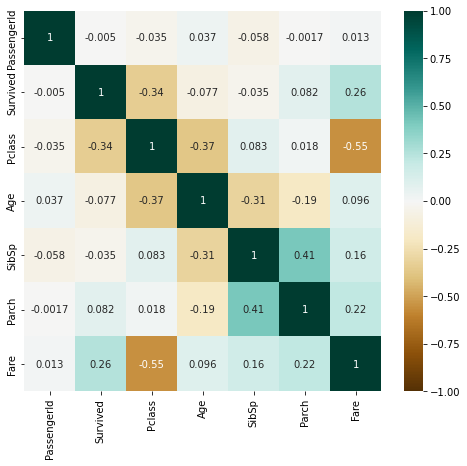

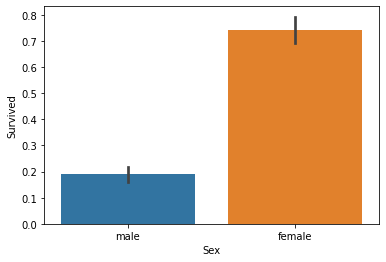

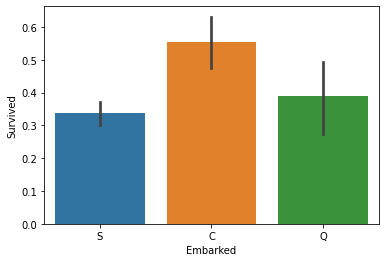

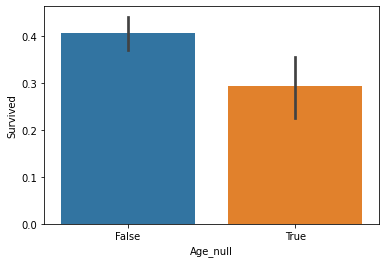

In [ ]:
# 正解ラベルとの関係を確認
# 変数間の相関係数をヒートマップ表示する

fig = plt.figure(figsize=(8,7))
ax = sns.heatmap(df_train.corr(), annot=True, cmap='BrBG', vmin=-1, vmax=1)


## カテゴリ変数(Sex)とSurvivedの関係

fig = plt.figure(figsize=(6,4))
ax = sns.barplot(y='Survived', x='Sex', data=df_train)

## カテゴリ変数(Embarked)とSurvivedの関係

fig = plt.figure(figsize=(6,4))
sns.barplot(y='Survived', x='Embarked', data=df_train)

# データの欠損の確認

print("●train\n{}".format(df_train.isnull().sum()))
print("●test\n{}".format(df_test.isnull().sum()))

## 年齢の欠損とSurvivedの関係
df_train["Age_null"] = df_train["Age"].isnull()
fig = plt.figure(figsize=(6,4))
sns.barplot(y='Survived', x='Age_null', data=df_train)
del df_train["Age_null"]




# モデルの学習

まずモデルに学習させるためのデータの加工を行う
学習させるモデルにはLightGBMを用いる

## 前処理
LightGBMにはカテゴリカル変数を使用することが可能。
LIMEのライブラリの都合上、欠損値を入力できない


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

def replace_name(series):
  """
  
  """
  # 敬称とりだす
  series = series.apply(lambda x: x.split(',')[1].split('.')[0].strip())
  series = series.replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer')
  # Capt キャプテン 
  series = series.replace(['Don', 'Sir', 'the Countess', 'Lady', 'Dona'], 'Royalty')
  # Dona 夫人 Lady 貴婦人 the Countess 伯爵夫人 Sir 閣下 Don
  series = series.replace(['Mme', 'Ms'], 'Mrs')
  series = series.replace(['Mlle'], 'Miss')
  series = series.replace(['Jonkheer'], 'Master')

  return series



In [ ]:
# カテゴリカル変数の定義

categorical_features = ["Sex", "Embarked", "Title"]

# 特徴量エンジニアリング

df_train = df_train.dropna(subset=["Embarked"])

df = pd.concat([df_train, df_test])
df['Family'] = df['SibSp'] + df['Parch'] + 1
df["Title"] = replace_name(df["Name"])
df["Age_null"] = df["Age"].isnull()
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df[df["Pclass"] == 3]["Fare"].median())
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'])

oe = OrdinalEncoder()
df[categorical_features] = oe.fit_transform(df[categorical_features]).astype(int)
df_train = df[df["Survived"].notnull()]
df_test = df[df["Survived"].isnull()].drop(columns=["Survived"])




In [ ]:
df_train.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Family,Title,Age_null
0,0.0,3,1,22.0,7.2500,2,2,2,False
1,1.0,1,0,38.0,71.2833,0,2,3,False
2,1.0,3,0,26.0,7.9250,2,1,1,False
3,1.0,1,0,35.0,53.1000,2,2,3,False
4,0.0,3,1,35.0,8.0500,2,1,2,False


In [ ]:
df_test.head()

,Pclass,Sex,Age,Fare,Embarked,Family,Title,Age_null
0,3,1,34.5,7.8292,1,1,2,False
1,3,0,47.0,7.0000,2,2,3,False
2,2,1,62.0,9.6875,1,1,2,False
3,3,1,27.0,8.6625,2,1,2,False
4,3,0,22.0,12.2875,2,3,3,False


In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_train, test_size=0.2, stratify=df_train["Survived"], random_state=100)

train.to_csv("/content/drive/MyDrive/Colab Notebooks/data/titanic/train_proc.csv", index=None)
valid.to_csv("/content/drive/MyDrive/Colab Notebooks/data/titanic/valid_proc.csv", index=None)
df_test.to_csv("/content/drive/MyDrive/Colab Notebooks/data/titanic/test_proc.csv", index=None)

In [ ]:
def make_Xy(df, col_y="Survived"):
  return df.drop(columns=[col_y]), df[col_y]

train_X, train_y = make_Xy(train)
valid_X, valid_y = make_Xy(valid)
test_X = df_test

## モデルの学習

In [ ]:
from lightgbm import LGBMClassifier
import pickle as pkl

model = LGBMClassifier(max_depth=4, colsample_bytree=0.5, reg_lambda=0.5, reg_alpha=0.5, importance_type="gain", random_state=100)

model.fit(
    train_X, train_y,
    eval_set=[(valid_X, valid_y)],
    early_stopping_rounds=50,
    verbose=10,
    categorical_feature=categorical_features
)

Training until validation scores don't improve for 50 rounds.
[10]	valid_0's binary_logloss: 0.505334
[20]	valid_0's binary_logloss: 0.453182
[30]	valid_0's binary_logloss: 0.430465
[40]	valid_0's binary_logloss: 0.420811
[50]	valid_0's binary_logloss: 0.421022
[60]	valid_0's binary_logloss: 0.420585
[70]	valid_0's binary_logloss: 0.418545
[80]	valid_0's binary_logloss: 0.417007
[90]	valid_0's binary_logloss: 0.416577
[100]	valid_0's binary_logloss: 0.417297
Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_logloss: 0.416514


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked', 'Sex', 'Title']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMClassifier(colsample_bytree=0.5, importance_type='gain', max_depth=4,
               random_state=100, reg_alpha=0.5, reg_lambda=0.5)

In [ ]:
print("Accuracy(train) {:.3f}".format(model.score(train_X, train_y)))
print("Accuracy(valid) {:.3f}".format(model.score(valid_X, valid_y)))


Accuracy(train) 0.866
Accuracy(valid) 0.815


In [ ]:
# モデルの保存

with open('/content/drive/MyDrive/Colab Notebooks/data/titanic/lgbm_model.pkl', 'wb') as f:
  pkl.dump(model, f)

## LIMEによる予測結果の説明

LIMEに実装されているLimeTabularExplainerを用いる

### LIMEを使う準備

準備するもの
1. 確率値を算出する関数
  LIMEでは、予測対象データが1件でも複数件でも入力できるように、予測関数を準備する
2. カテゴリカル変数の情報
  判断根拠を数値の形で算出するだけでなく、jupyter notebook上で表示できる機能の用意もある



In [ ]:
def predict_fn(X):
  if len(X.shape)==1:
    return model.predict_proba(X.reshape(1, -1))[0]
  else:
    return model.predict_proba(X)

class_names = ["Not Survived", "Survived"]
categorical_feature_idx = np.where(train_X.columns.isin(categorical_features))[0]
categorical_names = dict(zip(categorical_feature_idx, [list(lst) for lst in oe.categories_]))


## 主要なパラメータ

LimeTabularExplainerクラスインスタンス化し、その後explain_instanceメソッドで、予測対象データ１件１件に対してAIモデルの判断根拠を獲得する。

LimeTabularExplainer

### LimeTrabularExplainerクラスの主要なパラメータ
|パラメータ名|パラメータの意味|
|------------|----------------|
|training_data| 説明変数データ。指定したデータの分布を参考にしてダミーデータが生成される。|
|mode                 |タスクの指定。classification or regression|
|categorical_features |カテゴリカル変数の指定。内部処理をカテゴリカル変数として扱うようになる|
|kernel_width         |局所説明の度合いを指定する|
|discretize_continuous|数値変数のり参加するのかの設定。|

### explain_instanceメソッドの主要なパラメータ

|パラメータ名|パラメータの意味|
|-------------|---------------|
|data_row |予測対象データ|
|predict_fn |予測関数。単にAIモデルの食メソッドだけでなく、前処理なども含めることも可能|
|num_features |説明に使用する変数の最大数。|
|num_samples |生成するダミーデータの数|
|model_regressor |局所近似モデル。デフォルトはリッジ回帰|

In [ ]:
##